In [1]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd

### Prepare datasets

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the paths for the good quality and blurry image datasets
good_quality_path = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality'
blurry_path = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_blurry'

# Define the paths for the output classification datasets
output_path = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets'

# Classes in the dataset
classes = ['clear', 'cloudy', 'amber']

# Function to split and copy images
def split_and_copy_images(source_path, output_base_path, class_name, quality):
    files = os.listdir(source_path)
    
    # Skip if no files in the folder
    if not files:
        print(f"No files found in {source_path}, skipping...")
        return
    
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    # Define the train and test output directories
    train_output_path = os.path.join(output_base_path, class_name, 'train', quality)
    test_output_path = os.path.join(output_base_path, class_name, 'test', quality)

    # Create the train and test directories if they don't exist
    os.makedirs(train_output_path, exist_ok=True)
    os.makedirs(test_output_path, exist_ok=True)

    for file in train_files:
        src_file_path = os.path.join(source_path, file)
        if os.path.isfile(src_file_path):
            shutil.copy(src_file_path, os.path.join(train_output_path, file))

    for file in test_files:
        src_file_path = os.path.join(source_path, file)
        if os.path.isfile(src_file_path):
            shutil.copy(src_file_path, os.path.join(test_output_path, file))

# Process each class for both good quality and blurry datasets
for cls in classes:
    good_quality_class_path = os.path.join(good_quality_path, cls)
    blurry_class_path = os.path.join(blurry_path, cls)
    
    split_and_copy_images(good_quality_class_path, output_path, cls, 'good_quality')
    split_and_copy_images(blurry_class_path, output_path, cls, 'blurry')

# Print the paths of the output classification datasets
for cls in classes:
    print(f"{cls.capitalize()} dataset paths:")
    print(f"  Train/Good Quality: {os.path.join(output_path, cls, 'train', 'good_quality')}")
    print(f"  Train/Blurry: {os.path.join(output_path, cls, 'train', 'blurry')}")
    print(f"  Test/Good Quality: {os.path.join(output_path, cls, 'test', 'good_quality')}")
    print(f"  Test/Blurry: {os.path.join(output_path, cls, 'test', 'blurry')}")


No files found in /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_blurry/amber, skipping...
Clear dataset paths:
  Train/Good Quality: /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/clear/train/good_quality
  Train/Blurry: /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/clear/train/blurry
  Test/Good Quality: /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/clear/test/good_quality
  Test/Blurry: /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/clear/test/bl

## Image Classification for each of the classes (clear, cloudy and amber) to good/blurry classes

In [3]:
clear_dataset_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/clear/train"
cloudy_dataset_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/cloudy/train"
amber_dataset_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/amber/train"

In [3]:
# models to compare 
available_models = {
    'alexnet': models.alexnet,
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    'resnet152': models.resnet152,
    'resnext50_32x4d': models.resnext50_32x4d,
    'resnext101_32x8d': models.resnext101_32x8d,
    'wide_resnet50_2': models.wide_resnet50_2,
    'wide_resnet101_2': models.wide_resnet101_2,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'squeezenet1_1': models.squeezenet1_1,
    'densenet121': models.densenet121,
    'densenet169': models.densenet169,
    'densenet201': models.densenet201,
}

### Functions for creating dataloaders

In [8]:
from fastai.vision.all import *
import PIL

# Custom Transform to Resize with Padding
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

# Custom Transform to HSV using fastai's rgb2hsv
class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)

def get_dataloaders(dataset_path):
    # Define all DataLoaders configurations
    dataloaders_dict = {
        # "raw": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=Resize(128),
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        # "resize_with_padding": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=custom_transform(128),  # Adjust size as needed
        #     batch_tfms=aug_transforms(size=128),  # Apply data augmentation
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        # "convert_to_hsv": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=Resize(128),  # Resize before applying HSV transform
        #     batch_tfms=[RGB2HSV(), *aug_transforms(size=128)],
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        # "normalize_pixels": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=Resize(128),  # Resize before applying HSV transform
        #     batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=128)],
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        # "brightness_contrast": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=Resize(128), 
        #     batch_tfms=[Brightness(max_lighting=0.2, p=0.75), Contrast(max_lighting=0.2, p=0.75), *aug_transforms(size=128)],
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        # "combined_resize_padding_hsv": ImageDataLoaders.from_folder(
        # path=dataset_path,
        # item_tfms=custom_transform(size=128),  # Resize and HSV transform
        # batch_tfms=[
        #     RGB2HSV(),
        #     *aug_transforms(size=128, flip_vert=True, max_rotate=10)
        # ],
        # bs=16,
        # valid_pct=0.25
        # ),
        
        # "combined_hsv_normalize": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=Resize(128),  # Resize before applying HSV transform
        #     batch_tfms=[
        #         RGB2HSV(),
        #         Normalize.from_stats(*imagenet_stats),
        #         *aug_transforms(size=128)
        #     ],
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        # "combined_padding_normalize": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=custom_transform(128),  # Resize with padding
        #     batch_tfms=[
        #         Normalize.from_stats(*imagenet_stats),
        #         *aug_transforms(size=128)
        #     ],
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        # "combined_padding_brightness_contrast": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=custom_transform(128),  # Resize with padding
        #     batch_tfms=[
        #         Brightness(max_lighting=0.2, p=0.75),
        #         Contrast(max_lighting=0.2, p=0.75),
        #         *aug_transforms(size=128)
        #     ],
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        # "combined_hsv_brightness_contrast": ImageDataLoaders.from_folder(
        #     path=dataset_path,
        #     item_tfms=Resize(128),  # Resize before applying HSV transform
        #     batch_tfms=[
        #         RGB2HSV(),
        #         Brightness(max_lighting=0.2, p=0.75),
        #         Contrast(max_lighting=0.2, p=0.75),
        #         *aug_transforms(size=128)
        #     ],
        #     bs=16,
        #     valid_pct=0.25
        # ),
        
        "combined_all": ImageDataLoaders.from_folder(
            path=dataset_path,
            item_tfms=custom_transform(size=128),  # Resize and HSV transform
            batch_tfms=[
                RGB2HSV(),
                *aug_transforms(size=128, flip_vert=True, max_rotate=10),
                Brightness(max_lighting=0.2, p=0.75),
                Contrast(max_lighting=0.2, p=0.75),
            ],
            bs=16,
            valid_pct=0.25
        )
    }
    
    return dataloaders_dict

In [6]:
clear_dataloaders_dict = get_dataloaders(clear_dataset_path)
cloudy_dataloaders_dict = get_dataloaders(cloudy_dataset_path)
amber_dataloaders_dict = get_dataloaders(amber_dataset_path)

### Train Function

In [7]:
import matplotlib.pyplot as plt

def train_model(dataloaders_dict, model_name):
    from fastai.metrics import Precision, Recall, RocAucMulti
    from fastai.vision.all import vision_learner

    # Define the model architecture and metrics
    precision_macro = Precision(average='macro')
    recall_macro = Recall(average='macro')

    results = {}
    models = {}
    
    for name, dls in dataloaders_dict.items():
        print(f"Training with configuration: {name}")

        model = vision_learner(
            dls=dls,
            arch=available_models[model_name],
            metrics=[error_rate, precision_macro, recall_macro]
        )

        # Train the model
        model.fine_tune(epochs=25)

        # Get and store the results
        results[name] = model.validate()
        models[name] = model

    # Display the results
    for config, result in results.items():
        print(f"Results for {config}: {result}")

    return results, models

#### Clear Classification

In [ ]:
train_model(cloudy_dataloaders_dict, 'alexnet')

#### Cloudy Classification

In [29]:
train_model(cloudy_dataloaders_dict, 'alexnet')

Training with configuration: raw


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.770577,0.420775,0.184332,0.790130,0.805132,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.646205,0.375080,0.142857,0.835480,0.846807,00:00
1,0.479214,0.358247,0.147465,0.833872,0.828912,00:00
2,0.418711,0.393450,0.156682,0.824726,0.814827,00:00
3,0.386068,0.351711,0.138249,0.848482,0.832144,00:01
4,0.388564,0.286871,0.101382,0.884864,0.884864,00:00
5,0.338930,0.346998,0.138249,0.842996,0.842996,00:01
6,0.316636,0.397245,0.152074,0.825501,0.850810,00:00
7,0.315583,0.423985,0.184332,0.798792,0.834073,00:01
8,0.306058,0.291928,0.119816,0.873377,0.849460,00:00
9,0.235957,0.269163,0.101382,0.880519,0.895717,00:01


Training with configuration: resize_with_padding


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.971840,0.505535,0.184332,0.809365,0.819540,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.760260,0.482814,0.175115,0.819563,0.831034,00:01
1,0.702169,0.412352,0.161290,0.831836,0.833068,00:01
2,0.672227,0.402401,0.152074,0.842091,0.840760,00:01
3,0.622808,0.387108,0.161290,0.835858,0.825464,00:01
4,0.581458,0.369637,0.156682,0.836022,0.842617,00:01
5,0.522998,0.399497,0.119816,0.876381,0.873386,00:01
6,0.509058,0.410365,0.152074,0.841537,0.852166,00:01
7,0.508115,0.460308,0.152074,0.854741,0.827454,00:01
8,0.486664,0.312187,0.119816,0.873932,0.879089,00:01
9,0.450751,0.383809,0.161290,0.831836,0.833068,00:01


Training with configuration: convert_to_hsv


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.927757,0.386495,0.142857,0.848490,0.861529,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.612282,0.355946,0.119816,0.871735,0.884712,00:01
1,0.619048,0.403054,0.129032,0.862775,0.877193,00:01
2,0.542446,0.331207,0.119816,0.872137,0.878133,00:01
3,0.486097,0.374278,0.156682,0.835534,0.850251,00:01
4,0.438439,0.398324,0.138249,0.852967,0.865288,00:01
5,0.425022,0.317427,0.115207,0.876344,0.888471,00:01
6,0.379135,0.404161,0.129032,0.863445,0.879386,00:01
7,0.383785,0.314334,0.138249,0.852756,0.860902,00:01
8,0.405091,0.343895,0.142857,0.849098,0.863722,00:01
9,0.392726,0.411692,0.156682,0.837766,0.854637,00:01


Training with configuration: normalize_pixels


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.874590,0.601468,0.244240,0.765263,0.758631,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.612718,0.493963,0.175115,0.826115,0.825893,00:01
1,0.491336,0.456986,0.170507,0.831162,0.830655,00:01
2,0.456557,0.453815,0.156682,0.843400,0.843750,00:01
3,0.421103,0.463051,0.147465,0.852379,0.852679,00:01
4,0.443303,0.452931,0.152074,0.848803,0.847024,00:01
5,0.365319,0.439618,0.142857,0.858077,0.856250,00:01
6,0.350516,0.473274,0.142857,0.857460,0.856548,00:01
7,0.324390,0.373077,0.156682,0.843383,0.842857,00:01
8,0.311388,0.386617,0.152074,0.848210,0.847321,00:01
9,0.357307,0.434833,0.142857,0.863087,0.855060,00:01


Training with configuration: brightness_contrast


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.852335,0.475549,0.184332,0.808435,0.812456,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.484408,0.443050,0.161290,0.836374,0.826418,00:01
1,0.502724,0.425525,0.179724,0.816676,0.807303,00:01
2,0.523816,0.370545,0.156682,0.838274,0.835712,00:01
3,0.478852,0.395426,0.152074,0.841753,0.850423,00:01
4,0.394296,0.355049,0.152074,0.841994,0.843199,00:01
5,0.418606,0.380434,0.175115,0.817938,0.823820,00:01
6,0.362919,0.417942,0.152074,0.852347,0.830558,00:01
7,0.356823,0.415797,0.156682,0.838875,0.850159,00:01
8,0.342144,0.422228,0.188940,0.804467,0.812192,00:02
9,0.319759,0.335246,0.138249,0.858709,0.853021,00:01


Training with configuration: combined_resize_padding_hsv


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.947018,0.436829,0.175115,0.812576,0.825345,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.660990,0.461708,0.198157,0.793718,0.811955,00:01
1,0.689845,0.406406,0.184332,0.802669,0.812999,00:01
2,0.649376,0.414734,0.165899,0.824675,0.817720,00:01
3,0.608348,0.418489,0.156682,0.831502,0.845044,00:01
4,0.590718,0.394359,0.142857,0.857143,0.833606,00:01
5,0.549002,0.367753,0.147465,0.842411,0.842411,00:01
6,0.501117,0.433373,0.152074,0.837082,0.838735,00:01
7,0.493009,0.376048,0.152074,0.837009,0.853713,00:01
8,0.451796,0.445820,0.165899,0.827721,0.812727,00:01
9,0.416227,0.381164,0.138249,0.852260,0.852260,00:01


Training with configuration: combined_hsv_normalize


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.810029,0.450910,0.230415,0.800134,0.792826,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.614617,0.412566,0.198157,0.812125,0.816522,00:01
1,0.515575,0.351323,0.179724,0.822200,0.829652,00:01
2,0.512494,0.299188,0.142857,0.853576,0.860217,00:01
3,0.479034,0.320618,0.156682,0.842975,0.851087,00:01
4,0.412656,0.318255,0.142857,0.854199,0.861652,00:01
5,0.396807,0.301103,0.133641,0.862371,0.866783,00:01
6,0.409164,0.361580,0.147465,0.849233,0.856217,00:01
7,0.393003,0.283135,0.110599,0.887708,0.885348,00:01
8,0.345072,0.280093,0.138249,0.858483,0.865652,00:01
9,0.299920,0.255526,0.092166,0.904904,0.907087,00:01


Training with configuration: combined_padding_normalize


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.912522,0.457460,0.207373,0.774646,0.779054,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.758689,0.404125,0.179724,0.806452,0.825955,00:01
1,0.682015,0.388827,0.161290,0.827491,0.851596,00:01
2,0.654660,0.361550,0.156682,0.828289,0.841127,00:01
3,0.609117,0.397211,0.147465,0.838046,0.853948,00:01
4,0.511234,0.393470,0.138249,0.849889,0.849889,00:01
5,0.520934,0.381739,0.156682,0.828321,0.838314,00:01
6,0.517760,0.479678,0.188940,0.811714,0.838452,00:01
7,0.491158,0.360341,0.156682,0.830436,0.852380,00:01
8,0.447636,0.323712,0.115207,0.879424,0.867875,00:01
9,0.435363,0.304467,0.119816,0.867796,0.875530,00:01


Training with configuration: combined_padding_brightness_contrast


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.823139,0.504475,0.202765,0.779609,0.801033,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.655528,0.415817,0.152074,0.835374,0.824038,00:01
1,0.627921,0.394860,0.161290,0.822198,0.820141,00:01
2,0.607919,0.406887,0.170507,0.832686,0.781643,00:01
3,0.542349,0.382457,0.152074,0.830155,0.839765,00:01
4,0.547844,0.393864,0.156682,0.825134,0.842535,00:01
5,0.498939,0.377161,0.170507,0.811945,0.809953,00:01
6,0.459015,0.412859,0.152074,0.839554,0.817746,00:01
7,0.465798,0.342052,0.129032,0.860698,0.851080,00:01
8,0.408229,0.355068,0.133641,0.850673,0.856995,00:01
9,0.401175,0.347857,0.165899,0.816582,0.838638,00:01


Training with configuration: combined_hsv_brightness_contrast


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.900063,0.441997,0.216590,0.803179,0.831362,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.615255,0.376389,0.175115,0.825603,0.859906,00:01
1,0.613327,0.371660,0.161290,0.838005,0.873615,00:01
2,0.583712,0.331407,0.129032,0.856183,0.885681,00:01
3,0.573963,0.283737,0.115207,0.868790,0.893099,00:01
4,0.573886,0.272058,0.142857,0.843922,0.875117,00:01
5,0.506857,0.272823,0.124424,0.860435,0.889202,00:01
6,0.486146,0.272750,0.129032,0.855256,0.863662,00:01
7,0.454151,0.257020,0.124424,0.862603,0.895493,00:01
8,0.424357,0.237636,0.092166,0.902566,0.891831,00:01
9,0.415796,0.282097,0.129032,0.854253,0.869953,00:01


Training with configuration: combined_all


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.934131,0.441346,0.161290,0.822955,0.845558,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.703545,0.457146,0.156682,0.826505,0.833940,00:01
1,0.614896,0.457471,0.170507,0.814117,0.808137,00:01
2,0.561174,0.451535,0.142857,0.848854,0.832447,00:01
3,0.571368,0.457916,0.175115,0.807030,0.822788,00:01
4,0.559069,0.472300,0.156682,0.830316,0.821809,00:01
5,0.515618,0.390565,0.147465,0.837069,0.841032,00:01
6,0.494253,0.407128,0.119816,0.874150,0.859276,00:01
7,0.485997,0.446645,0.175115,0.811768,0.837953,00:01
8,0.476915,0.349555,0.124424,0.870104,0.852697,00:01
9,0.419627,0.428656,0.147465,0.835998,0.847098,00:01


Results for raw: [0.3431016504764557, 0.10138248652219772, 0.8895024875621891, 0.8776287864171329]
Results for resize_with_padding: [0.2481851577758789, 0.09677419066429138, 0.8987403100775193, 0.9002210433244916]
Results for convert_to_hsv: [0.33487963676452637, 0.11981566995382309, 0.8716086956521739, 0.8825187969924813]
Results for normalize_pixels: [0.3093346655368805, 0.12442396581172943, 0.8787448347107438, 0.8741071428571429]
Results for brightness_contrast: [0.3234454095363617, 0.13364055752754211, 0.8601811906816221, 0.8677325581395349]
Results for combined_resize_padding_hsv: [0.2671280801296234, 0.09677419066429138, 0.8958897922312556, 0.8978304284676834]
Results for combined_hsv_normalize: [0.19974173605442047, 0.08294931054115295, 0.9150869565217392, 0.9150869565217392]
Results for combined_padding_normalize: [0.26715874671936035, 0.11520737409591675, 0.873139070442992, 0.8791274672569636]
Results for combined_padding_brightness_contrast: [0.31398871541023254, 0.1244239658

#### Amber Classification

In [30]:
train_model(amber_dataloaders_dict, 'alexnet')

Training with configuration: raw


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.948658,0.564434,0.263158,0.717949,0.702381,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.083874,0.641510,0.421053,0.572222,0.577381,00:00
1,0.880680,0.699877,0.473684,0.533333,0.535714,00:00
2,0.795576,0.722316,0.473684,0.533333,0.535714,00:00
3,0.694363,0.756447,0.368421,0.638889,0.648810,00:00
4,0.619543,0.771364,0.315789,0.677778,0.690476,00:00
5,0.543180,0.806875,0.315789,0.677778,0.690476,00:00
6,0.487610,0.887526,0.315789,0.677778,0.690476,00:00
7,0.468328,0.927046,0.315789,0.677778,0.690476,00:00
8,0.438248,0.977014,0.315789,0.677778,0.690476,00:00
9,0.408318,1.019171,0.368421,0.613636,0.619048,00:00


Training with configuration: resize_with_padding


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.377484,0.838016,0.421053,0.577381,0.572222,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.394842,0.725498,0.421053,0.585714,0.566667,00:00
1,1.222758,0.672878,0.421053,0.585714,0.566667,00:00
2,1.170074,0.627958,0.315789,0.690476,0.677778,00:00
3,1.075509,0.585367,0.263158,0.738889,0.738889,00:00
4,1.039188,0.575051,0.315789,0.693182,0.688889,00:00
5,0.980472,0.581350,0.315789,0.693182,0.688889,00:00
6,0.946407,0.584817,0.315789,0.693182,0.688889,00:00
7,0.898526,0.545928,0.315789,0.693182,0.688889,00:00
8,0.858963,0.565484,0.315789,0.683333,0.683333,00:00
9,0.843949,0.601198,0.315789,0.683333,0.683333,00:00


Training with configuration: convert_to_hsv


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.770850,1.098628,0.578947,0.450000,0.465909,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.937350,0.975928,0.421053,0.583333,0.585227,00:00
1,1.080549,0.924662,0.368421,0.647727,0.647727,00:00
2,1.072762,0.814978,0.368421,0.647727,0.647727,00:00
3,1.005258,0.754144,0.368421,0.647727,0.647727,00:00
4,0.993195,0.681838,0.368421,0.627778,0.630682,00:00
5,0.939790,0.623421,0.421053,0.583333,0.585227,00:00
6,0.915776,0.622177,0.315789,0.720238,0.710227,00:00
7,0.932257,0.579717,0.315789,0.720238,0.710227,00:00
8,0.919649,0.535095,0.315789,0.720238,0.710227,00:00
9,0.850137,0.518822,0.263158,0.755682,0.755682,00:00


Training with configuration: normalize_pixels


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.298861,0.938579,0.421053,0.544118,0.517045,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.406097,0.896448,0.473684,0.277778,0.454545,00:00
1,1.337964,0.835099,0.421053,0.544118,0.517045,00:00
2,1.155601,0.751444,0.368421,0.645833,0.579545,00:00
3,1.064025,0.676200,0.421053,0.557692,0.551136,00:00
4,1.063601,0.653604,0.263158,0.757143,0.704545,00:00
5,1.014753,0.659418,0.263158,0.757143,0.704545,00:00
6,0.938123,0.699852,0.315789,0.679487,0.659091,00:00
7,0.856096,0.759640,0.421053,0.550000,0.534091,00:00
8,0.795150,0.743399,0.368421,0.621429,0.596591,00:00
9,0.760493,0.771849,0.315789,0.679487,0.659091,00:00


Training with configuration: brightness_contrast


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.560844,0.938536,0.631579,0.647059,0.571429,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.057150,0.747626,0.421053,0.566667,0.585714,00:00
1,1.042162,0.650889,0.263158,0.673077,0.692857,00:00
2,0.887009,0.595946,0.263158,0.650000,0.628571,00:00
3,0.772880,0.580250,0.315789,0.592857,0.592857,00:00
4,0.746606,0.586063,0.315789,0.592857,0.592857,00:00
5,0.727271,0.654810,0.421053,0.517857,0.521429,00:00
6,0.744228,0.615121,0.526316,0.461111,0.450000,00:00
7,0.750975,0.548061,0.368421,0.596591,0.621429,00:00
8,0.768792,0.485299,0.210526,0.728571,0.728571,00:00
9,0.757913,0.411665,0.157895,0.808333,0.764286,00:00


Training with configuration: combined_resize_padding_hsv


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.252196,1.035862,0.473684,0.488636,0.485714,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.077211,1.013043,0.526316,0.461111,0.450000,00:00
1,1.081318,0.985884,0.578947,0.433333,0.414286,00:00
2,1.077813,0.895129,0.526316,0.461111,0.450000,00:00
3,1.038447,0.805042,0.473684,0.488636,0.485714,00:00
4,1.018209,0.734288,0.473684,0.488636,0.485714,00:00
5,0.991800,0.664503,0.421053,0.566667,0.585714,00:00
6,0.921248,0.594258,0.368421,0.596591,0.621429,00:00
7,0.896660,0.592615,0.368421,0.596591,0.621429,00:00
8,0.876556,0.556192,0.368421,0.596591,0.621429,00:00
9,0.848344,0.495654,0.263158,0.704545,0.757143,00:00


Training with configuration: combined_hsv_normalize


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.341745,1.141349,0.473684,0.522222,0.522727,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.053082,1.128725,0.421053,0.568182,0.568182,00:00
1,1.120625,1.061931,0.421053,0.568182,0.568182,00:00
2,1.131023,1.005581,0.421053,0.568182,0.568182,00:00
3,1.155839,0.899651,0.368421,0.627778,0.630682,00:00
4,1.077511,0.853531,0.263158,0.733333,0.738636,00:00
5,1.034288,0.820838,0.263158,0.733333,0.738636,00:00
6,0.932503,0.848600,0.263158,0.733333,0.738636,00:00
7,0.902220,0.804368,0.263158,0.733333,0.738636,00:00
8,0.853057,0.908032,0.263158,0.733333,0.738636,00:00
9,0.798284,1.023182,0.315789,0.688889,0.693182,00:00


Training with configuration: combined_padding_normalize


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.132440,0.796417,0.421053,0.467949,0.458333,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.985440,0.866139,0.526316,0.426136,0.391667,00:00
1,0.971853,0.939372,0.473684,0.511111,0.516667,00:00
2,0.907994,0.993352,0.526316,0.488889,0.483333,00:00
3,0.900075,1.009034,0.473684,0.511111,0.516667,00:00
4,0.855346,1.076230,0.473684,0.511111,0.516667,00:00
5,0.845481,1.009746,0.368421,0.559524,0.583333,00:00
6,0.813672,0.953262,0.368421,0.559524,0.583333,00:00
7,0.761687,0.912623,0.421053,0.534091,0.550000,00:00
8,0.761092,0.939662,0.421053,0.594444,0.641667,00:00
9,0.712531,0.921914,0.526316,0.488889,0.483333,00:00


Training with configuration: combined_padding_brightness_contrast


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.203575,0.850151,0.421053,0.577778,0.577778,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.094308,0.876407,0.368421,0.633333,0.633333,00:00
1,0.962672,0.873078,0.368421,0.633333,0.633333,00:00
2,0.885756,0.908703,0.421053,0.577778,0.577778,00:00
3,0.887668,0.974238,0.368421,0.630682,0.627778,00:00
4,0.794534,1.051451,0.421053,0.577778,0.577778,00:00
5,0.726037,1.201100,0.368421,0.630682,0.627778,00:00
6,0.666696,1.267182,0.368421,0.630682,0.627778,00:00
7,0.616646,1.282637,0.368421,0.630682,0.627778,00:00
8,0.588912,1.420056,0.473684,0.519231,0.516667,00:00
9,0.592199,1.518574,0.421053,0.577381,0.572222,00:00


Training with configuration: combined_hsv_brightness_contrast


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.089152,1.320531,0.789474,0.260417,0.335714,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.173542,1.001471,0.473684,0.538889,0.550000,00:00
1,1.138287,0.886441,0.368421,0.596591,0.621429,00:00
2,1.132499,0.894745,0.421053,0.517857,0.521429,00:00
3,1.042359,0.975784,0.473684,0.488636,0.485714,00:00
4,1.038301,1.055185,0.421053,0.517857,0.521429,00:00
5,0.964648,0.976664,0.315789,0.592857,0.592857,00:00
6,0.923201,0.868625,0.263158,0.650000,0.628571,00:00
7,0.857860,0.788333,0.263158,0.650000,0.628571,00:00
8,0.786355,0.725231,0.263158,0.650000,0.628571,00:00
9,0.734009,0.699166,0.210526,0.728571,0.728571,00:00


Training with configuration: combined_all


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.126968,1.233943,0.789474,0.198864,0.205556,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.047598,1.206375,0.789474,0.198864,0.205556,00:00
1,1.112283,1.146937,0.684211,0.316667,0.316667,00:00
2,1.125484,1.037535,0.578947,0.422222,0.422222,00:00
3,1.132847,0.946727,0.578947,0.422222,0.422222,00:00
4,1.075145,0.875402,0.578947,0.422222,0.422222,00:00
5,1.051640,0.861595,0.368421,0.648810,0.638889,00:00
6,1.025225,0.814194,0.368421,0.648810,0.638889,00:00
7,0.977613,0.715000,0.315789,0.683333,0.683333,00:00
8,0.916081,0.666835,0.368421,0.630682,0.627778,00:00
9,0.879777,0.642956,0.368421,0.630682,0.627778,00:00


Results for raw: [1.0949912071228027, 0.3684210479259491, 0.6136363636363636, 0.6190476190476191]
Results for resize_with_padding: [0.7357688546180725, 0.31578946113586426, 0.6931818181818181, 0.6888888888888889]
Results for convert_to_hsv: [0.6942769289016724, 0.3684210479259491, 0.6477272727272727, 0.6477272727272727]
Results for normalize_pixels: [1.0755382776260376, 0.3684210479259491, 0.6214285714285714, 0.5965909090909092]
Results for brightness_contrast: [0.34183838963508606, 0.10526315867900848, 0.8642857142857143, 0.8642857142857143]
Results for combined_resize_padding_hsv: [0.4228271543979645, 0.15789473056793213, 0.8125, 0.8928571428571428]
Results for combined_hsv_normalize: [0.9134017825126648, 0.2631579041481018, 0.7556818181818181, 0.7556818181818181]
Results for combined_padding_normalize: [0.879795491695404, 0.4736842215061188, 0.4464285714285714, 0.425]
Results for combined_padding_brightness_contrast: [1.917028784751892, 0.42105263471603394, 0.5773809523809523, 0.572

### Blurry Classification for all classes together

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the paths for the good quality and blurry image datasets
good_quality_path = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_good_quality'
blurry_path = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_blurry'

# Define the paths for the output classification datasets
output_path = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/all_classes'

# Classes in the dataset
classes = ['clear', 'cloudy', 'amber']

# Function to collect and split images from multiple classes
def collect_and_split_images(source_base_path, output_base_path):
    all_images = []

    for cls in classes:
        class_path = os.path.join(source_base_path, cls)
        files = [os.path.join(class_path, file) for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))]
        all_images.extend(files)

    # Split the combined images into train and test sets
    train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

    # Create output directories for train and test
    train_good_output_path = os.path.join(output_base_path, 'train', 'good_quality')
    test_good_output_path = os.path.join(output_base_path, 'test', 'good_quality')
    train_blurry_output_path = os.path.join(output_base_path, 'train', 'blurry')
    test_blurry_output_path = os.path.join(output_base_path, 'test', 'blurry')

    os.makedirs(train_good_output_path, exist_ok=True)
    os.makedirs(test_good_output_path, exist_ok=True)
    os.makedirs(train_blurry_output_path, exist_ok=True)
    os.makedirs(test_blurry_output_path, exist_ok=True)

    return train_files, test_files, train_good_output_path, test_good_output_path, train_blurry_output_path, test_blurry_output_path

# Collect and split images for both good quality and blurry datasets
train_good, test_good, train_good_output, test_good_output, _, _ = collect_and_split_images(good_quality_path, output_path)
train_blurry, test_blurry, _, _, train_blurry_output, test_blurry_output = collect_and_split_images(blurry_path, output_path)

# Copy the files to the respective directories
for file in train_good:
    shutil.copy(file, os.path.join(train_good_output, os.path.basename(file)))
for file in test_good:
    shutil.copy(file, os.path.join(test_good_output, os.path.basename(file)))
for file in train_blurry:
    shutil.copy(file, os.path.join(train_blurry_output, os.path.basename(file)))
for file in test_blurry:
    shutil.copy(file, os.path.join(test_blurry_output, os.path.basename(file)))

print(f"Images have been organized and split into train and test sets at {output_path}")


Images have been organized and split into train and test sets at /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/all_classes


In [9]:
all_classes_dataloader_dict = get_dataloaders(output_path)

Training with configuration: combined_all


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.799964,0.548200,0.233083,0.746194,0.761650,00:06


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.618961,0.422210,0.174812,0.805782,0.817716,00:04
1,0.552297,0.392368,0.163534,0.820319,0.816092,00:02
2,0.509702,0.345190,0.144737,0.841368,0.836863,00:03
3,0.500317,0.352622,0.142857,0.843182,0.839580,00:03
4,0.463080,0.358662,0.167293,0.816109,0.811938,00:03
5,0.401587,0.375700,0.150376,0.831884,0.850481,00:03
6,0.401214,0.362377,0.142857,0.862758,0.816529,00:03
7,0.378327,0.374802,0.172932,0.810920,0.835801,00:03
8,0.362650,0.353935,0.146617,0.835695,0.850793,00:03
9,0.339964,0.372326,0.172932,0.808282,0.825556,00:03


Results for combined_all: [0.31415534019470215, 0.1428571492433548, 0.840976460331299, 0.8664730134932533]


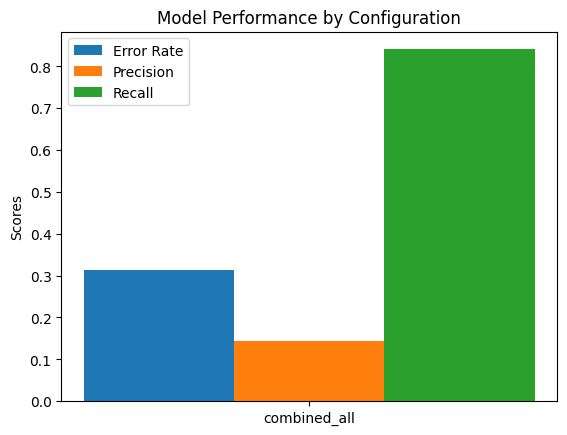

In [10]:
results, models = train_model(all_classes_dataloader_dict, 'alexnet')

In [11]:
dls = all_classes_dataloader_dict['combined_all']
model = models['combined_all']

In [12]:
model_path = '/home/etaylor/code_projects/thesis/checkpoints/blur_image_classification/alexnet.pkl'
model.export(model_path)

In [21]:
# load the model
model = load_learner(model_path)

In [13]:
TEST_DATASET_PATH = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/all_classes/test"

# evaluate on the test set
from sklearn.metrics import precision_score, recall_score, accuracy_score


item_tfms=custom_transform(size=128),  # Resize and HSV transform
batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

# Create the test DataLoader with the same transformations
test_dl = dls.test_dl(get_image_files(TEST_DATASET_PATH), with_labels=True, 
                    item_tfms=item_tfms, batch_tfms=batch_tfms)


# Evaluate on the test set
preds, targs = model.get_preds(dl=test_dl)


if targs is not None:
    pred_classes = preds.argmax(dim=1).numpy()
    true_classes = targs.numpy()

    precision = precision_score(true_classes, pred_classes, average='macro')
    recall = recall_score(true_classes, pred_classes, average='macro')
    accuracy = accuracy_score(true_classes, pred_classes)
else:
    precision = recall = accuracy = None

results = {
    'model': "alexnet",
    'precision': precision,
    'recall': recall,
    'accuracy': accuracy
}

results

{'model': 'alexnet',
 'precision': 0.9014791881664946,
 'recall': 0.9241634967169821,
 'accuracy': 0.9154929577464789}

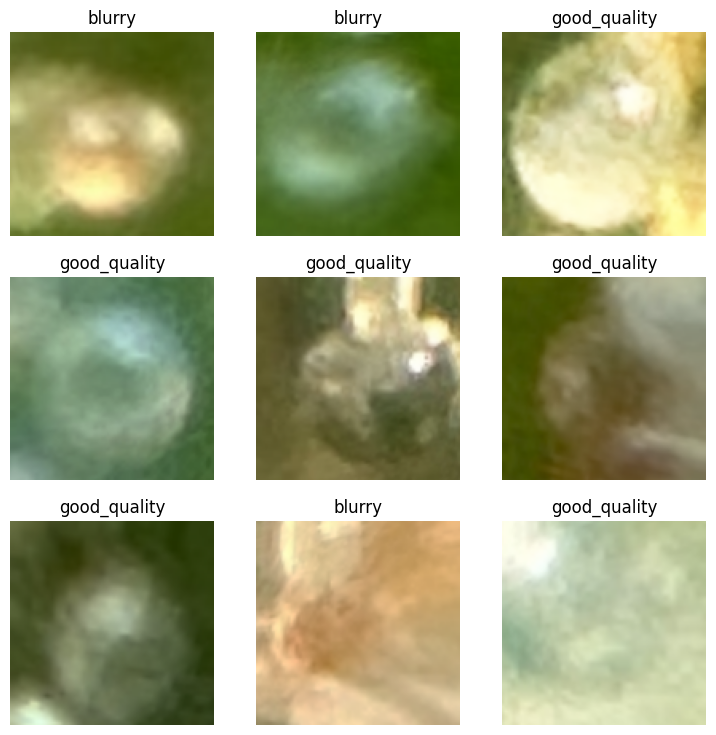

In [14]:
dls.show_batch()

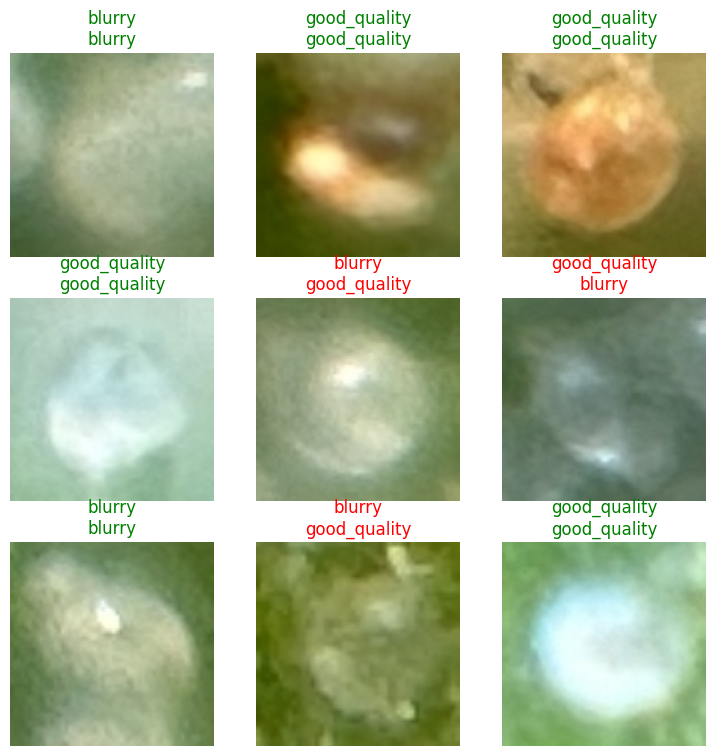

In [15]:
model.show_results()

In [17]:
interp = Interpretation.from_learner(model)

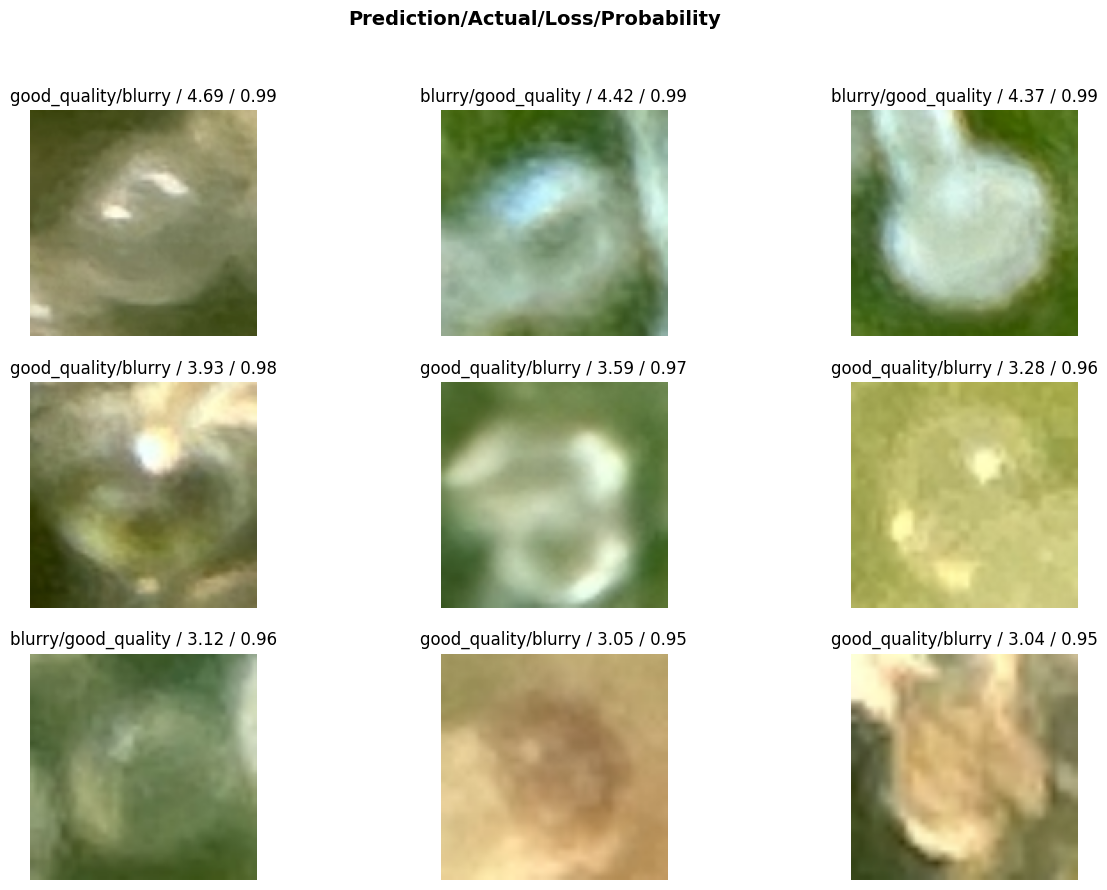

In [18]:
interp.plot_top_losses(9, figsize=(15,10))